In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/movie_prediction_data/tmdb_1000_sample.csv')

In [3]:
import pandas as pd

# Loading CSV
# df = pd.read_csv('tmdb_enriched_movies.csv')

# Cleaning column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Converting data types
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
num_cols = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Dropping rows with missing budget or revenue
df.dropna(subset=['budget', 'revenue'], inplace=True)

# Stripping and lowercasing text fields
text_cols = ['language', 'genres', 'production_companies', 'top_cast', 'keywords', 'status']
for col in text_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()

# Splitting multi-value columns
df['genres_list'] = df['genres'].str.split(', ')
df['top_cast_list'] = df['top_cast'].str.split(', ')
df['keywords_list'] = df['keywords'].str.split(', ')

# Removing duplicate entries
df.drop_duplicates(subset=['movie_id', 'title'], inplace=True)

# Filtering out invalid rows
df = df[(df['budget'] >= 0) & (df['revenue'] >= 0) & (df['runtime'] > 0)]

# (TBD) Removing unwanted columns

# Previewing final dataset
df.head()


movie_id     imdb_id                         title  vote_average  \
0    299534   tt4154796             Avengers: Endgame         8.238   
1     76600   tt1630029      Avatar: The Way of Water         7.609   
2    140607   tt2488496  Star Wars: The Force Awakens         7.300   
3    299536   tt4154756        Avengers: Infinity War         8.235   
4    634649  tt10872600       Spider-Man: No Way Home         7.946   

   vote_count    status release_date     budget     revenue  popularity  ...  \
0       26214  released   2019-04-24  356000000  2799439100     26.9856  ...   
1       12445  released   2022-12-14  460000000  2320250281     24.4638  ...   
2       19667  released   2015-12-15  245000000  2068223624     13.0107  ...   
3       30394  released   2018-04-25  300000000  2052415039     34.0939  ...   
4       20666  released   2021-12-15  200000000  1921847111     30.3377  ...   

                                production_companies       director  \
0                                     marvel studios  Anthony Russo   
1     20th century studios, lightstorm entertainment  James Cameron   
2                          lucasfilm ltd., bad robot    J.J. Abrams   
3                                     marvel studios      Joe Russo   
4  marvel studios, pascal pictures, columbia pict...      Jon Watts   

                                          top_cast  \
0     robert downey jr., chris evans, mark ruffalo   
1   sam worthington, zoe salda침a, sigourney weaver   
2        harrison ford, mark hamill, carrie fisher   
3  robert downey jr., chris evans, chris hemsworth   
4       tom holland, zendaya, benedict cumberbatch   

                                            keywords      profit  year  \
0  superhero, time travel, space travel, time mac...  2443439100  2019   
1  dying and death, loss of loved one, alien life...  1860250281  2022   
2           android, spacecraft, space opera, requel  1823223624  2015   
3  sacrifice, magic, superhero, based on comic, s...  1752415039  2018   
4  new york city, hero, showdown, magic, loss of ...  1721847111  2021   

  distance_from_mean                           genres_list  \
0       2.376558e+09  [adventure, science fiction, action]   
1       1.793369e+09  [science fiction, adventure, action]   
2       1.756342e+09  [adventure, action, science fiction]   
3       1.685534e+09  [adventure, action, science fiction]   
4       1.654966e+09  [action, adventure, science fiction]   

                                       top_cast_list  \
0     [robert downey jr., chris evans, mark ruffalo]   
1   [sam worthington, zoe salda침a, sigourney weaver]   
2        [harrison ford, mark hamill, carrie fisher]   
3  [robert downey jr., chris evans, chris hemsworth]   
4       [tom holland, zendaya, benedict cumberbatch]   

                                       keywords_list  
0  [superhero, time travel, space travel, time ma...  
1  [dying and death, loss of loved one, alien lif...  
2         [android, spacecraft, space opera, requel]  
3  [sacrifice, magic, superhero, based on comic, ...  
4  [new york city, hero, showdown, magic, loss of...  

[5 rows x 23 columns]

In [4]:
# Saving the cleaned dataset to a new CSV file
df.to_csv('/content/drive/MyDrive/movie_prediction_data/tmdb_1000_sample_cleaned.csv', index=False)


[0]	validation_0-rmse:4.74789	validation_1-rmse:4.63617
[100]	validation_0-rmse:1.50660	validation_1-rmse:1.78955
[200]	validation_0-rmse:1.41188	validation_1-rmse:1.78128
[248]	validation_0-rmse:1.36752	validation_1-rmse:1.78219

游늵 Validation Results:
MAE: 23,493,934.23
RMSE: 73,459,080.97
Custom 췀10M Accuracy: 65.23%

游늵 Test Results:
MAE: 23,461,026.11
RMSE: 63,021,622.95
Custom 췀10M Accuracy: 64.78%


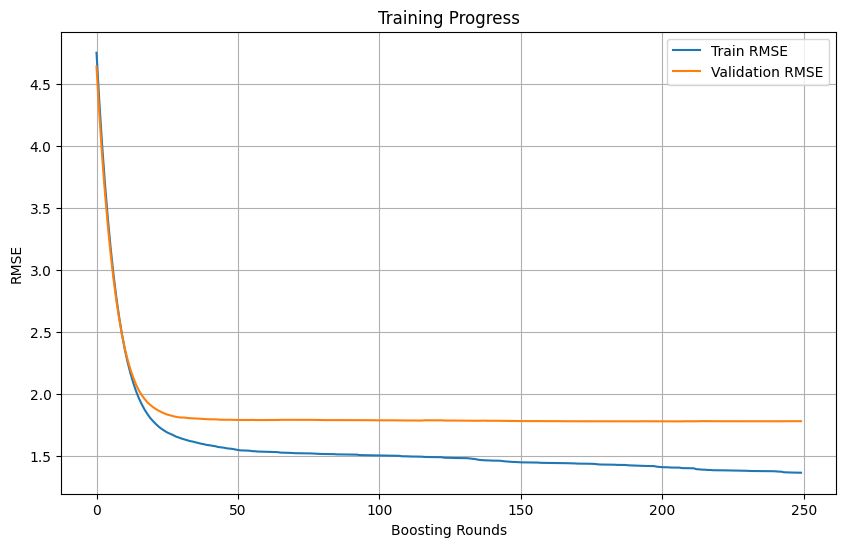

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# === 1. Loading cleaned dataset ===
df = pd.read_csv('/content/drive/My Drive/cleaned_movies_dataset.csv')

# === 2. Converting release_date column to datetime format ===
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# === 3. Performing feature engineering ===
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['cast_count'] = df['top_cast'].fillna('').str.split(', ').apply(len)
df['genre_count'] = df['genres'].fillna('').str.split(', ').apply(len)
df['keyword_count'] = df['keywords'].fillna('').str.split(', ').apply(len)

# Extracting top 50 directors and encoding others as 'other'
top_directors = df['director'].value_counts().nlargest(50).index
df['director_clean'] = df['director'].apply(lambda x: x if x in top_directors else 'other')

# Extracting top 50 production companies and encoding others as 'other'
df['main_prod_company'] = df['production_companies'].str.split(', ').str[0]
top_companies = df['main_prod_company'].value_counts().nlargest(50).index
df['main_prod_company'] = df['main_prod_company'].apply(lambda x: x if x in top_companies else 'other')

# Applying log transformation to the revenue column
df['log_revenue'] = np.log1p(df['revenue'])

# === 4. Applying one-hot encoding to categorical features ===
categorical_cols = ['language', 'status', 'main_prod_company', 'director_clean']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# === 5. Defining features and target column ===
drop_cols = ['movie_id', 'imdb_id', 'title', 'revenue', 'release_date',
             'genres', 'top_cast', 'keywords', 'production_companies',
             'director', 'genres_list', 'top_cast_list', 'keywords_list']

features = [col for col in df.columns if col not in drop_cols + ['log_revenue']]
X = df[features]
y = df['log_revenue']

# === 6. Splitting dataset into training, validation, and test sets ===
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

# === 7. Initializing the XGBoost model with tracking and early stopping ===
model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50
)

evals = [(X_train, y_train), (X_val, y_val)]

# === 8. Fitting the model and monitoring progress ===
model.fit(
    X_train, y_train,
    eval_set=evals,
    verbose=100
)

# === 9. Defining evaluation function with custom accuracy ===
def evaluate(model, X, y_true, label):
    y_pred = model.predict(X)
    y_pred_rev = np.expm1(y_pred)
    y_true_rev = np.expm1(y_true)

    mae = mean_absolute_error(y_true_rev, y_pred_rev)
    rmse = np.sqrt(mean_squared_error(y_true_rev, y_pred_rev))
    within_range = np.abs(y_pred_rev - y_true_rev) <= 10000000
    custom_acc = np.mean(within_range)

    print(f"\n游늵 {label} Results:")
    print(f"MAE: {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"Custom 췀10M Accuracy: {custom_acc * 100:.2f}%")

# === 10. Plotting training progress ===
def plot_training_progress(model):
    evals_result = model.evals_result()
    plt.figure(figsize=(10, 6))
    plt.plot(evals_result['validation_0']['rmse'], label='Train RMSE')
    plt.plot(evals_result['validation_1']['rmse'], label='Validation RMSE')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('RMSE')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True)
    plt.show()

# === 11. Evaluating model performance ===
evaluate(model, X_val, y_val, "Validation")
evaluate(model, X_test, y_test, "Test")

# === 12. Displaying RMSE plot over boosting rounds ===
plot_training_progress(model)
